# From detected synch cues, produce restamped raw Equivital and fixed intervals on march 5th, Tuesday

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [4]:
cues_df = pd.read_csv('./outfiles/'+'Cue_dev_align_20240305.csv',index_col = 0)
for c in cues_df.columns:
    if c.endswith('dt') or c.endswith('dTime'):
        if c.startswith('dur'):
            cues_df[c] = pd.to_timedelta(cues_df[c])
        else:
            cues_df[c] = pd.to_datetime(cues_df[c])
cues_df

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
VN104,2024-03-04 07:56:26.776549291,-0.523438,0.554719,2024-03-05 15:29:59.669177905,23.683594,0.344493,1 days 07:33:32.892628614,113612.892628,-18.197401,-0.576520,3420456,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762811791,./outfiles/cue23_20240305.csv,cue3_20240305,2024-03-05 15:30:14.852841270
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN101,2024-03-05 07:42:21.729502905,0.542969,0.508130,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265


In [6]:
# {'cue1_20240309': Timestamp('2024-03-09 12:29:20.294512472'),
#  'cue2_20240309': Timestamp('2024-03-09 16:43:11.326464853')}
df_timings = pd.DataFrame(columns=['Event','Event_Type','SS_sTime','SS_dTime'])
Event_data = {'Event':'','Event_Type':'','SS_sTime':0,'SS_dTime':pd.to_timedelta('nan')}
# start of the synch spider audio 
sync_start = (pd.to_datetime('2024-03-05 07:42:22.272471655')-pd.to_timedelta(8.272472 ,unit='s')).tz_localize(None)

In [7]:
# 19059.7765
i=0
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_Start'
event_dets['SS_sTime']= 8.272472 
event_dets['SS_dTime']= pd.to_datetime('2024-03-05 07:42:22.272471655').tz_localize(None)
df_timings.loc[i,:]=event_dets

i=1
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_End'
event_dets['SS_sTime']= 22245.859163
event_dets['SS_dTime']= pd.to_datetime('2024-03-05 13:52:59.859163265').tz_localize(None) 
df_timings.loc[i,:]=event_dets

i=2
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_End2'
event_dets['SS_sTime']= 28080.852841
event_dets['SS_dTime']= pd.to_datetime('2024-03-05 15:30:14.852841270').tz_localize(None) 
df_timings.loc[i,:]=event_dets


i=3
event_dets = Event_data.copy()
event_dets['Event']='RD'
event_dets['Event_Type']='Concert_Start'
event_dets['SS_sTime']= 10539.883
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets
# C5 tuning 6223.778
# C6 tuning 284.247 + 12170.971
i=4
event_dets = Event_data.copy()
event_dets['Event']='RD'
event_dets['Event_Type']='Concert_End'
event_dets['SS_sTime']= 12170.971 + 2121.326
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets


df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,8.272472,2024-03-05 07:42:22.272471655
1,Sync,Sync_End,22245.859163,2024-03-05 13:52:59.859163265
2,Sync,Sync_End2,28080.852841,2024-03-05 15:30:14.852841270
3,RD,Concert_Start,10539.883,2024-03-05 10:37:53.882999655
4,RD,Concert_End,14292.297,2024-03-05 11:40:26.296999655


In [8]:
for ev in ['RD']:
    df_t = df_timings.query('Event == @ev').reset_index(drop = True)
    print(df_t)

  Event     Event_Type   SS_sTime                       SS_dTime
0    RD  Concert_Start  10539.883  2024-03-05 10:37:53.882999655
1    RD    Concert_End  14292.297  2024-03-05 11:40:26.296999655


In [9]:
# the problem recordings are 'VN104' and 'LS404'
# both use Sync_End2 for their final sync cue
# 'VN104' effectively doesn't have a start cue, so we will use the median drift for that device to compensate
# but measuring from the end
['VN104','LS404']
df_drifts=pd.read_csv('./outfiles/'+'dev_drift.csv', index_col=0)
df_drifts.loc['VN104','median_C']

1.0001425887879094

In [10]:
df_shifts=pd.read_csv('./outfiles/Cue_dev_align_20240305.csv', index_col=0)
df_shifts['Cue1_devdTime'] = pd.to_datetime(df_shifts['Cue1_devdTime']).dt.tz_localize(None)
df_shifts['Cue2_devdTime'] = pd.to_datetime(df_shifts['Cue2_devdTime']).dt.tz_localize(None)
df_shifts['dur_dt'] = pd.to_timedelta(df_shifts['dur_dt'])
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
VN104,2024-03-04 07:56:26.776549291,-0.523438,0.554719,2024-03-05 15:29:59.669177905,23.683594,0.344493,1 days 07:33:32.892628614,113612.892628,-18.197401,-0.576520,3420456,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762811791,./outfiles/cue23_20240305.csv,cue3_20240305,2024-03-05 15:30:14.852841270
VN109,2024-03-05 07:42:22.440440405,-0.167969,0.495985,2024-03-05 13:52:58.187296655,1.671875,0.678457,0 days 06:10:35.746856250,22235.746856,-1.839835,-0.297847,5022010,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN110,2024-03-05 07:42:21.792002905,0.480469,0.453417,2024-03-05 13:52:57.886515405,1.972656,0.719188,0 days 06:10:36.094512500,22236.094512,-1.492179,-0.241566,5022026,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN111,2024-03-05 07:42:22.936534155,-0.664062,0.517515,2024-03-05 13:52:59.007609155,0.851562,0.691417,0 days 06:10:36.071075,22236.071075,-1.515616,-0.245360,5022027,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN201,2024-03-05 07:42:22.475596655,-0.203125,0.540951,2024-03-05 13:52:58.585734155,1.273438,0.631014,0 days 06:10:36.110137500,22236.110137,-1.476554,-0.239036,5022050,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN101,2024-03-05 07:42:21.729502905,0.542969,0.508130,2024-03-05 13:52:55.956827905,3.902344,0.640513,0 days 06:10:34.227325,22234.227325,-3.359366,-0.543841,3420415,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN105,2024-03-05 07:42:23.065440405,-0.792969,0.539531,2024-03-05 13:52:57.456827905,2.402344,0.596965,0 days 06:10:34.391387500,22234.391387,-3.195304,-0.517282,3420755,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VN212,2024-03-05 07:42:23.874034155,-1.601562,0.543279,2024-03-05 13:52:59.804484155,0.054688,0.675412,0 days 06:10:35.930450,22235.930450,-1.656241,-0.268126,5022256,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265
VA304,2024-03-05 07:42:21.952159155,0.320312,0.678878,2024-03-05 13:52:57.909952905,1.949219,0.784027,0 days 06:10:35.957793750,22235.957794,-1.628897,-0.263699,5022110,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265


In [11]:
data_dir='/Volumes/SeagateHub/BiC2024/20240305/Equivital/Extracted SEM Data/'

sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN104,DATA,3420456,240304,101,DATA-VN104-3420456-24030400_0.CSV,csv,644696,2024-03-04 07:33:10+00:00,2024-03-05 15:30:25+00:00,115035.0,...,[VN104],3420456.0,VN104,53.0,4,100.0,0.0,1.0,Stationary,Supine
VN109,DATA,5022010,240305,101,DATA-VN109-5022010-24030500_0.CSV,csv,135078,2024-03-05 07:16:27+00:00,2024-03-05 13:55:12+00:00,23925.0,...,[VN109],5022010.0,VN109,53.0,84,98.0,0.0,0.0,Stationary,Upright
VN110,DATA,5022026,240305,0,DATA-VN110-5022026-24030500.CSV,csv,134591,2024-03-05 07:16:29+00:00,2024-03-05 13:53:59+00:00,23850.0,...,[VN110],5022026.0,VN110,53.0,81,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,5022027,240305,101,DATA-VN111-5022027-24030500_0.CSV,csv,134993,2024-03-05 07:16:32+00:00,2024-03-05 13:55:47+00:00,23955.0,...,[VN111],5022027.0,VN111,53.0,74,97.0,0.0,1.0,Stationary,Upright
VN201,DATA,5022050,240305,101,DATA-VN201-5022050-24030500_0.CSV,csv,134530,2024-03-05 07:16:34+00:00,2024-03-05 13:54:19+00:00,23865.0,...,[VN201],5022050.0,VN201,53.0,62,98.0,0.0,0.0,Stationary,Upright


# Test Realign and cut
test alignment of sync cues 1 and 2 with clock corrections applied to two SEM measurements

In [28]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [23]:
pid = 'VN109'
dets = df_datafiles.loc[pid,:]
dets

Signal                                                            DATA
ID                                                             5022050
Date                                                            240305
Session                                                            101
FileName                             DATA-VN201-5022050-24030500_0.CSV
FileType                                                           csv
FileSize                                                        134530
RecStart                                     2024-03-05 07:16:34+00:00
RecEnd                                       2024-03-05 13:54:19+00:00
Duration                                                       23865.0
BatteryStart                                                      4135
BatteryEnd                                                        3982
BatteryChange(mV)                                                 -153
FullLoc              /Volumes/SeagateHub/BiC2024/20240305/Equivital...
DATAlo

In [29]:
df_shifts.loc[pid,:]

Cue1_devdTime                          2024-03-05 07:42:22.475596655
Cue1_s                                                     -0.203125
Cue1_r                                                      0.540951
Cue2_devdTime                          2024-03-05 13:52:58.585734155
Cue2_s                                                      1.273438
Cue2_r                                                      0.631014
dur_dt                                     0 days 06:10:36.110137500
dur_s                                                   22236.110137
drift_s                                                    -1.476554
drift_rate_sphr                                            -0.239036
devID                                                        5022050
ACCFile            /Volumes/Seagatehub/BiC2024/20240305/Equivital...
Cue1_file                               ./outfiles/cue1_20240305.csv
Cue1_name                                              cue1_20240305
Cue1_dt                           

In [27]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
print(drift_C)
ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]


,dev_dTime,X,Y,Z,signal
0,2024-03-05 07:16:06.007,0,0,0,0.0
1,2024-03-05 07:16:06.011,0,0,0,0.0
2,2024-03-05 07:16:06.015,0,0,0,0.0
3,2024-03-05 07:16:06.019,0,0,0,0.0
4,2024-03-05 07:16:06.023,0,0,0,0.0


In [22]:
ACC1 = ACC.copy()

In [ ]:
pid = 'VN201'

V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
print(drift_C)
ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]


Test out put: are these two signals aligned in rTime_s, in rTime_dt?

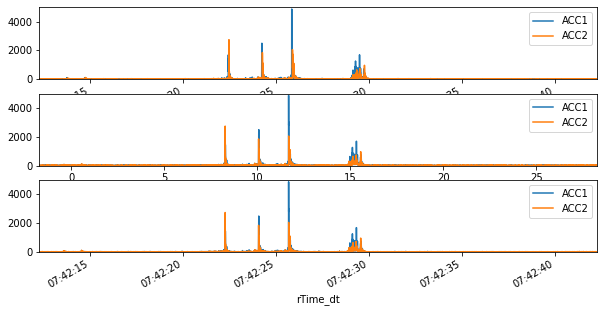

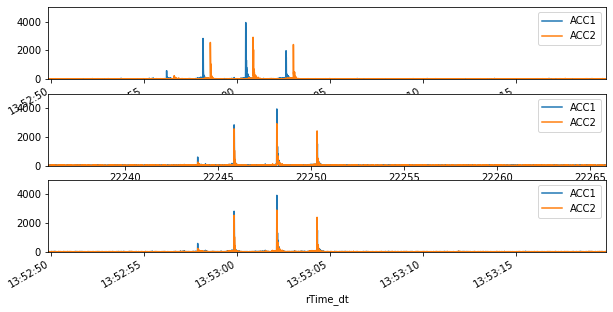

In [32]:
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[0,'SS_sTime']-10,df_timings.loc[0,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[0,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[0,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
    
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[1,'SS_sTime']-10,df_timings.loc[1,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[1,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[1,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
     

The correction looks about right, so we proceed to apply it to tall the measurements

# Output full and for each event


In [28]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [35]:
CUTLOGS = pd.concat([df_datafiles,df_shifts],axis=1)#,CUTLOGS
CUTS= pd.Series()
# CUTS[pid] = []

newdata_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/'

sig_map = {'DATAloc':'EQDATA','ACCloc':'EQBACC','RESPloc':'EQRESP','RRloc':'EQCIBI','ECGloc':'EQ2ECG'}
cut_ind = 0
toc = time.time()
rec_day = '20240305'
buff = pd.to_timedelta(15,unit='s') # 2 minute buffer on cutes for concert and stuff pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s')
segmentid = 'FULL'

for pid in CUTLOGS.index: # had to restart after VN212 as that is missing 
    tic = time.time()
    outfiles = []
    tic = time.time()
    if pid == 'VN104': # use estimate
        drift_C = df_drifts.loc[pid,'median_C']
    else: 
        if pid == 'LS404': #use the second cue
            drift_C = (df_timings.loc[2,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
        else:
            drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
    eqfiles = df_datafiles.loc[pid,['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']]
    for f in eqfiles.index:
        SignalID = sig_map[f]
        V = pd.read_csv(eqfiles[f],skipinitialspace=True)
        dt_col = V.columns[0] # assume first column is time, specifically datetime
        sig_col = V.columns[1:]
        V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize(None) # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
        if pid == 'VN104': # have to use synch at end
            V['rTime_s'] =np.round((V[dt_col]-df_shifts.loc[pid,'Cue2_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[2,'SS_sTime']
        else:
            V['rTime_s'] =np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        V['rTime_dt'] = pd.to_timedelta(V['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig = pd.DataFrame()
        RecTimeSig['rec_sTime'] = np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig['dev_dTime'] = V[dt_col]
        RecTimeSig.loc[:,sig_col] = V[sig_col]
        
        seg_filename = '_'.join([pid,rec_day,'FULL',SignalID+'.csv'])
        new_col_order=['rec_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        RecTimeSig[new_col_order].to_csv(newdata_dir + 'FullDay/'+ rec_day+ '/'+ seg_filename, index = False)

        new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        
        # run through events in that section
        ev = 'RD'
        df_t = df_timings.query('Event == @ev').reset_index(drop = True)
        subsig  = al.dt_cut(RecTimeSig,'rec_dTime',df_t.loc[0,'SS_dTime']-buff,df_t.loc[1,'SS_dTime']+buff)
        if subsig is not None:
            subsig['c_sTime'] = np.round((subsig['rec_dTime']-df_t.loc[0,'SS_dTime']).dt.total_seconds(),4)
            seg_filename = '_'.join([ev,segmentid,pid,SignalID+'.csv'])
            outfiles.append(seg_filename)
            subsig[new_col_order].to_csv(newdata_dir + ev+'/' + seg_filename, index = False)

        print(' '.join([pid,SignalID ,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))
    CUTS[pid] = outfiles # not run with this but could


# CUTS= pd.Series()
# CUTS[pid] = []
CUTLOGS['Output_files']=CUTS
CUTLOGS.to_csv('./outfiles/'+rec_day+'EQIVITALS_CUTLOGS.csv')
# CUTLOGS['Scaling_C'].hist()
# plt.show()
CUTLOGS

VN104 EQDATA 0.202 0.203
VN104 EQBACC 312.83 312.831
VN104 EQRESP 340.171 340.172
VN104 EQCIBI 340.727 340.728
VN104 EQ2ECG 665.052 665.053
VN109 EQDATA 0.267 665.321
VN109 EQBACC 66.867 731.92
VN109 EQRESP 73.05 738.104
VN109 EQCIBI 73.476 738.529
VN109 EQ2ECG 144.893 809.947
VN110 EQDATA 0.14 810.087
VN110 EQBACC 67.099 877.046
VN110 EQRESP 73.51 883.458
VN110 EQCIBI 74.008 883.955
VN110 EQ2ECG 145.824 955.772
VN111 EQDATA 0.146 955.918
VN111 EQBACC 66.554 1022.325
VN111 EQRESP 72.863 1028.635
VN111 EQCIBI 73.32 1029.091
VN111 EQ2ECG 145.721 1101.493
VN201 EQDATA 0.167 1101.66
VN201 EQBACC 65.738 1167.231
VN201 EQRESP 71.857 1173.35
VN201 EQCIBI 72.242 1173.735
VN201 EQ2ECG 143.241 1244.734
VN101 EQDATA 0.188 1244.922
VN101 EQBACC 67.276 1312.011
VN101 EQRESP 73.518 1318.252
VN101 EQCIBI 73.764 1318.498
VN101 EQ2ECG 145.248 1389.982
VN105 EQDATA 0.131 1390.113
VN105 EQBACC 66.6 1456.583
VN105 EQRESP 72.967 1462.95
VN105 EQCIBI 73.225 1463.208
VN105 EQ2ECG 144.919 1534.902
VN212 EQDAT

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt,Output_files
DevName,,,,,,,,,,,,,,,,,,,,,
VN104,DATA,3420456,240304,101,DATA-VN104-3420456-24030400_0.CSV,csv,644696,2024-03-04 07:33:10+00:00,2024-03-05 15:30:25+00:00,115035.0,...,-0.576520,3420456,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762811791,./outfiles/cue23_20240305.csv,cue3_20240305,2024-03-05 15:30:14.852841270,NaN
VN109,DATA,5022010,240305,101,DATA-VN109-5022010-24030500_0.CSV,csv,135078,2024-03-05 07:16:27+00:00,2024-03-05 13:55:12+00:00,23925.0,...,-0.297847,5022010,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VN110,DATA,5022026,240305,0,DATA-VN110-5022026-24030500.CSV,csv,134591,2024-03-05 07:16:29+00:00,2024-03-05 13:53:59+00:00,23850.0,...,-0.241566,5022026,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VN111,DATA,5022027,240305,101,DATA-VN111-5022027-24030500_0.CSV,csv,134993,2024-03-05 07:16:32+00:00,2024-03-05 13:55:47+00:00,23955.0,...,-0.245360,5022027,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VN201,DATA,5022050,240305,101,DATA-VN201-5022050-24030500_0.CSV,csv,134530,2024-03-05 07:16:34+00:00,2024-03-05 13:54:19+00:00,23865.0,...,-0.239036,5022050,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VN101,DATA,3420415,240305,101,DATA-VN101-3420415-24030500_0.CSV,csv,135328,2024-03-05 07:18:17+00:00,2024-03-05 13:55:32+00:00,23835.0,...,-0.543841,3420415,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VN105,DATA,3420755,240305,0,DATA-VN105-3420755-24030500.CSV,csv,133501,2024-03-05 07:18:23+00:00,2024-03-05 13:55:23+00:00,23820.0,...,-0.517282,3420755,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VN212,DATA,5022256,240305,101,DATA-VN212-5022256-24030500_0.CSV,csv,132100,2024-03-05 07:18:52+00:00,2024-03-05 13:55:52+00:00,23820.0,...,-0.268126,5022256,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN
VA304,DATA,5022110,240305,0,DATA-VA304-5022110-24030500.CSV,csv,133645,2024-03-05 07:19:51+00:00,2024-03-05 13:55:06+00:00,23715.0,...,-0.263699,5022110,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,NaN


In [64]:
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             3420426
Date                                                            240308
Session                                                              0
FileName                               DATA-AU802-3420426-24030800.CSV
FileType                                                           csv
FileSize                                                        156433
RecStart                                     2024-03-08 06:34:21+00:00
RecEnd                                       2024-03-08 14:25:51+00:00
Duration                                                       28290.0
BatteryStart                                                      4123
BatteryEnd                                                        3953
BatteryChange(mV)                                                 -170
FullLoc              /Volumes/SeagateHub/BiC2024/20240308/Equivital...
DATAlo

In [47]:
eqfiles

DATAloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ACCloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RESPloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RRloc      /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ECGloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
Name: VN211, dtype: object

In [ ]:
# 4099.328 for all segments